In [357]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split  # divide datos en conj de entrenamiento y prueba
from sklearn.linear_model import LinearRegression # para crear el modelo de regresion lineal.
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer # Import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [359]:
metano = pd.read_csv("metano.csv", sep=',', header=0)
dioxido = pd.read_csv("dioxidodecarbono.csv", sep=',', header=0)
temperatura = pd.read_csv("temperaturaglobal.csv", sep=',', header=0)



In [361]:
print(metano.columns)
print(dioxido.columns)
print(temperatura.columns)


Index(['year', 'month', 'decimal', 'average', 'average_unc', 'trend',
       'trend_unc'],
      dtype='object')
Index(['year', 'Unnamed: 1', 'date', 'monthly average', 'de-season alized',
       'days', 'st.dev of days', 'unc. of mon mean'],
      dtype='object')
Index(['year', 'No_Smoothing', 'Lowess(5)'], dtype='object')


In [379]:
# Unir los datos
data = metano.merge(dioxido, on='year').merge(temperatura, on='year')


In [381]:
# Inspeccionar las primeras filas y estadísticas básicas del DataFrame
print("Datos combinados:")
print(data.head())

# Ver las estadísticas descriptivas para entender la distribución de los datos
print(data.describe())

# Revisar los tipos de datos de cada columna
print(data.dtypes)

# Verificar si hay valores nulos en el DataFrame
print(data.isnull().sum())


Datos combinados:
   year  month   decimal  average  average_unc    trend  trend_unc  \
0  1983      7  1983.542  1625.95         2.19  1634.95       1.42   
1  1983      7  1983.542  1625.95         2.19  1634.95       1.42   
2  1983      7  1983.542  1625.95         2.19  1634.95       1.42   
3  1983      7  1983.542  1625.95         2.19  1634.95       1.42   
4  1983      7  1983.542  1625.95         2.19  1634.95       1.42   

   Unnamed: 1       date  monthly average  de-season alized  days  \
0           2  1983.1250           342.78            342.25    24   
1           3  1983.2083           343.37            341.85    27   
2           4  1983.2917           345.40            342.76    23   
3           5  1983.3750           346.14            342.97    28   
4           6  1983.4583           345.76            343.30    20   

   st.dev of days  unc. of mon mean  No_Smoothing  Lowess(5)  
0            0.37              0.15          0.31       0.21  
1            0.88   

In [383]:
# Convertir las columnas a tipo numérico
# Usaremos `errors='coerce'` para convertir cualquier valor no numérico en NaN

# Asegurándonos de convertir las columnas que deberían ser numéricas
data['year'] = pd.to_numeric(data['year'], errors='coerce')  # Asegurarnos de que 'year' sea numérico
data['average'] = pd.to_numeric(data['average'], errors='coerce')  # Metano
data['monthly average'] = pd.to_numeric(data['monthly average'], errors='coerce')  # CO₂
data['No_Smoothing'] = pd.to_numeric(data['No_Smoothing'], errors='coerce')  # Temperatura

# Verificar los tipos de datos después de la conversión
print(data.dtypes)


year                  int64
month                 int64
decimal             float64
average             float64
average_unc         float64
trend               float64
trend_unc           float64
Unnamed: 1            int64
date                float64
monthly average     float64
de-season alized    float64
days                  int64
st.dev of days      float64
unc. of mon mean    float64
No_Smoothing        float64
Lowess(5)           float64
dtype: object


In [385]:
# Eliminar filas con valores nulos en cualquier columna
data.dropna(inplace=True)

# Verificar si se eliminaron valores nulos
print(data.isnull().sum())


year                0
month               0
decimal             0
average             0
average_unc         0
trend               0
trend_unc           0
Unnamed: 1          0
date                0
monthly average     0
de-season alized    0
days                0
st.dev of days      0
unc. of mon mean    0
No_Smoothing        0
Lowess(5)           0
dtype: int64


In [387]:
# Verificar si hay filas duplicadas
print(f"Filas duplicadas: {data.duplicated().sum()}")

# Eliminar las filas duplicadas si existen
data.drop_duplicates(inplace=True)

# Verificar si las duplicadas fueron eliminadas
print(f"Filas duplicadas después de la limpieza: {data.duplicated().sum()}")


Filas duplicadas: 0
Filas duplicadas después de la limpieza: 0


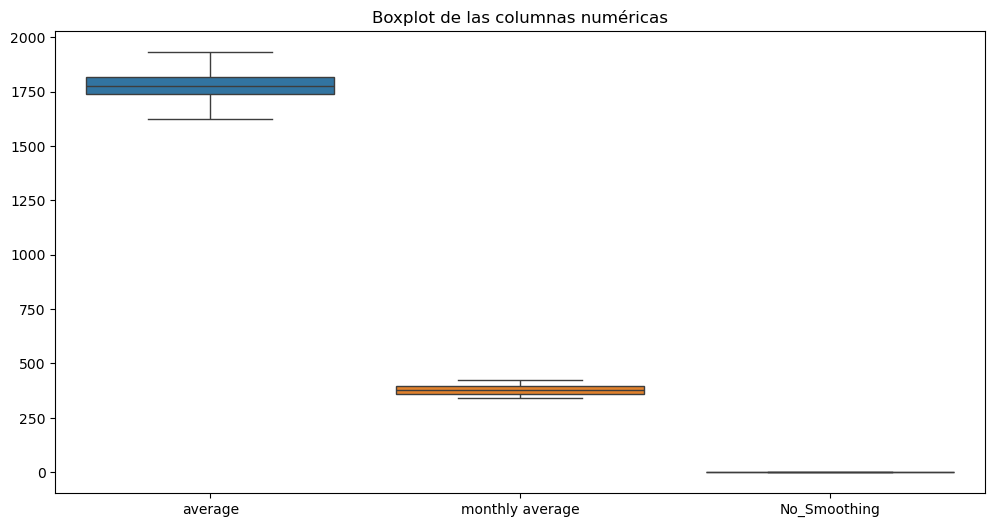

In [389]:
# Revisar si hay valores atípicos en las columnas usando un gráfico de caja (boxplot)
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(data=data[['average', 'monthly average', 'No_Smoothing']])
plt.title('Boxplot de las columnas numéricas')
plt.show()


In [391]:
# Mostrar las primeras filas del DataFrame limpio
print(data.head())

# Estadísticas descriptivas de las columnas numéricas
print(data.describe())


   year  month   decimal  average  average_unc    trend  trend_unc  \
0  1983      7  1983.542  1625.95         2.19  1634.95       1.42   
1  1983      7  1983.542  1625.95         2.19  1634.95       1.42   
2  1983      7  1983.542  1625.95         2.19  1634.95       1.42   
3  1983      7  1983.542  1625.95         2.19  1634.95       1.42   
4  1983      7  1983.542  1625.95         2.19  1634.95       1.42   

   Unnamed: 1       date  monthly average  de-season alized  days  \
0           2  1983.1250           342.78            342.25    24   
1           3  1983.2083           343.37            341.85    27   
2           4  1983.2917           345.40            342.76    23   
3           5  1983.3750           346.14            342.97    28   
4           6  1983.4583           345.76            343.30    20   

   st.dev of days  unc. of mon mean  No_Smoothing  Lowess(5)  
0            0.37              0.15          0.31       0.21  
1            0.88              0.32   

Matriz de correlación:
                      year     month   decimal   average  average_unc  \
year              1.000000 -0.017083  0.999697  0.969842    -0.110206   
month            -0.017083  1.000000  0.007538  0.021957    -0.028005   
decimal           0.999697  0.007538  1.000000  0.970497    -0.110909   
average           0.969842  0.021957  0.970497  1.000000    -0.158952   
average_unc      -0.110206 -0.028005 -0.110909 -0.158952     1.000000   
trend             0.972509  0.009778  0.972864  0.997736    -0.150129   
trend_unc        -0.140175  0.035381 -0.139320 -0.178633     0.467720   
Unnamed: 1       -0.002849  0.001411 -0.002815 -0.003441     0.003844   
date              0.999697 -0.017044  0.999395  0.969532    -0.110086   
monthly average   0.991835 -0.015186  0.991578  0.964256    -0.085896   
de-season alized  0.994746 -0.015238  0.994487  0.967088    -0.086167   
days              0.306552 -0.010820  0.306322  0.363128    -0.178303   
st.dev of days    0.162837 -

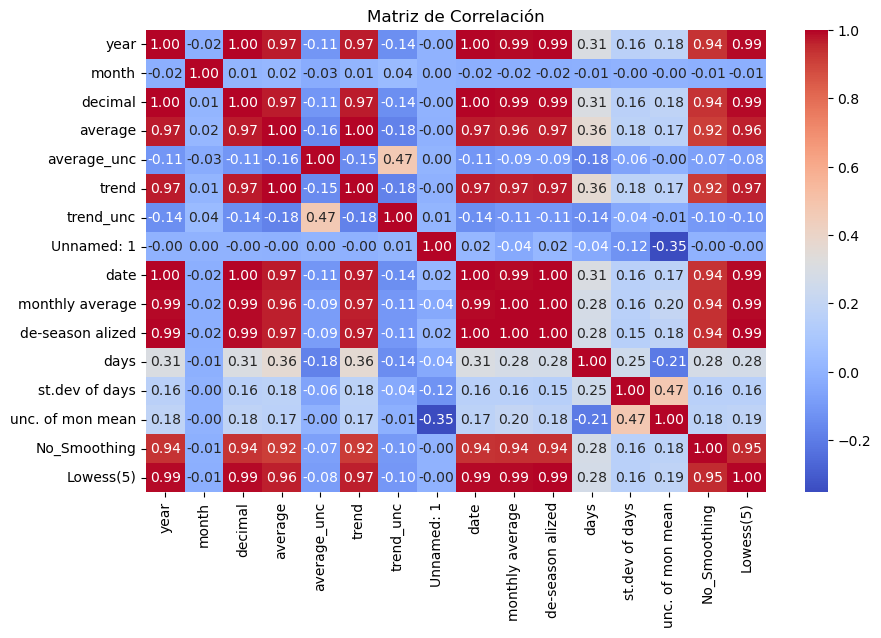

In [393]:
# Matriz de correlación
correlation_matrix = data.corr()
print("Matriz de correlación:")
print(correlation_matrix)

# Visualización de la correlación
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()


Análisis de Tendencia de la Concentración de Metano y Dióxido de Carbono a lo Largo del Tiempo

Concentración de Metano: de la columna "average" del dataset de metano, que representa la concentración promedio mensual.
Concentración de Dióxido de Carbono: de la columna "monthly average" del dataset de dióxido de carbono.

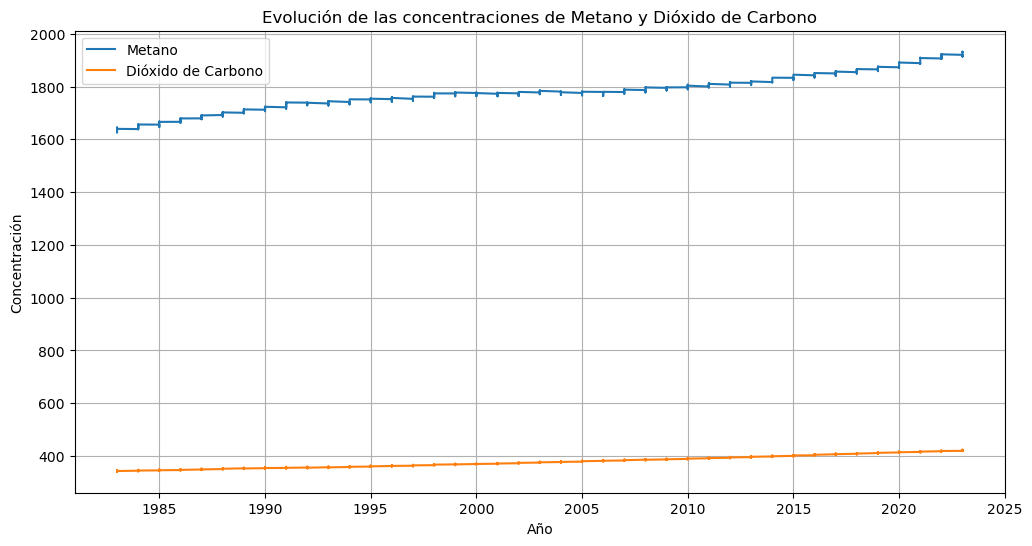

In [395]:
import pandas as pd
import matplotlib.pyplot as plt

# Suponiendo que tus datos están en DataFrames llamados 'df_metano' y 'df_co2'
plt.figure(figsize=(12, 6))
plt.plot(data['year'], data['average'], label='Metano')
plt.plot(data['year'], data['monthly average'], label='Dióxido de Carbono')
plt.xlabel('Año')
plt.ylabel('Concentración')
plt.title('Evolución de las concentraciones de Metano y Dióxido de Carbono')
plt.legend()
plt.grid(True)
plt.show()

Comparacion de la temperatura con las concentraciones de gases
Temperatura: de la columna "No_Smoothing" del dataset de temperatura, que representa la anomalía de temperatura anual.
Concentración de Metano:  la misma columna que en el análisis anterior.
Concentración de Dióxido de Carbono:  la misma columna que en el análisis anterior.

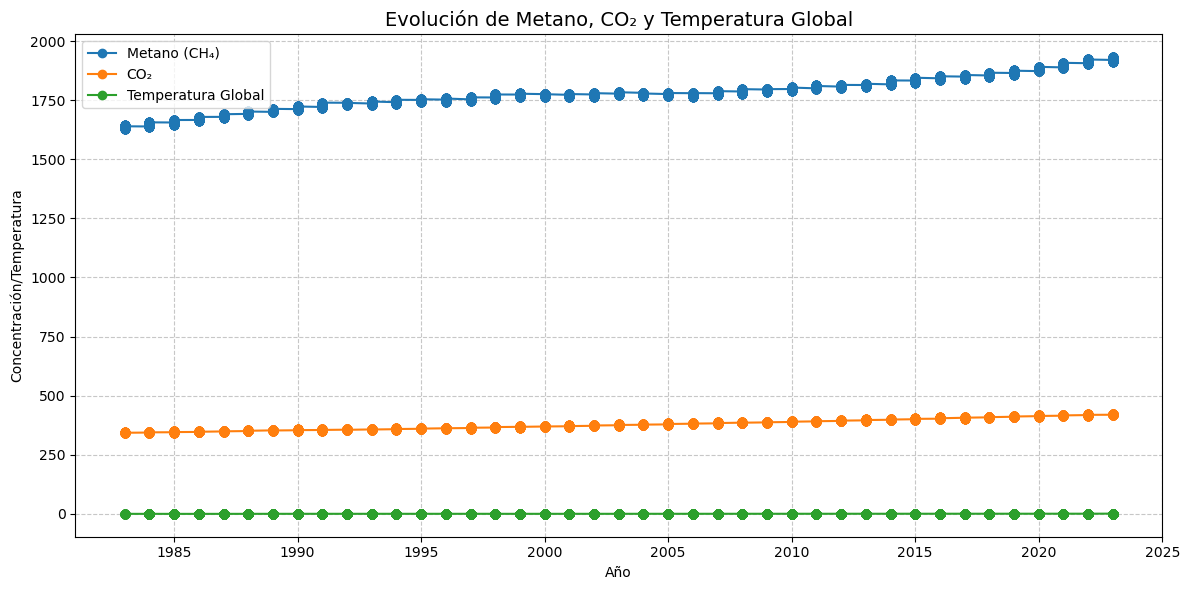

In [397]:
plt.figure(figsize=(12, 6))
plt.plot(data['year'], data['average'], label='Metano (CH₄)', marker="o")
plt.plot(data['year'], data['monthly average'], label='CO₂', marker="o")
plt.plot(data['year'], data['No_Smoothing'], label='Temperatura Global', marker="o")
plt.xlabel('Año')
plt.ylabel('Concentración/Temperatura')
plt.title('Evolución de Metano, CO₂ y Temperatura Global', fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


 explorando la correlación entre las concentraciones de gases y la temperatura global.

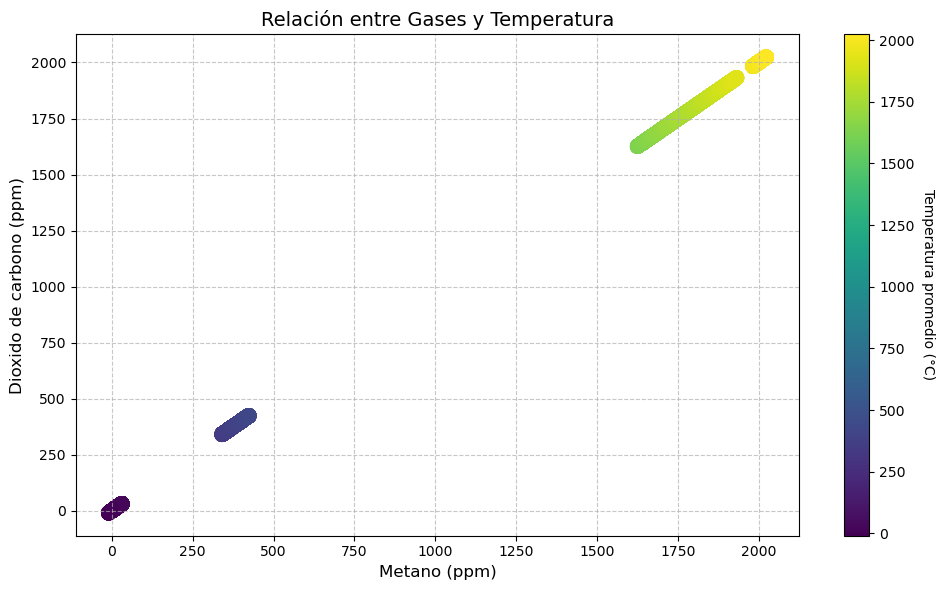

In [399]:
import matplotlib.pyplot as plt

average = [data]  #concentracion de metano
monthly_average = [data] #concentracion de CO2
No_smoothing = [data]  # Temperatura promedio

# Crear el gráfico
plt.figure(figsize=(10, 6))
sc = plt.scatter(average, monthly_average, c=No_smoothing, cmap='viridis', s=100)

# Configurar colorbar para los años
cbar = plt.colorbar(sc)
cbar.set_label('Temperatura promedio (°C)', rotation=270, labelpad=15)

# Etiquetas y título
plt.title('Relación entre Gases y Temperatura', fontsize=14)
plt.xlabel('Metano (ppm)', fontsize=12)
plt.ylabel('Dioxido de carbono (ppm)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


# Análisis Estacional

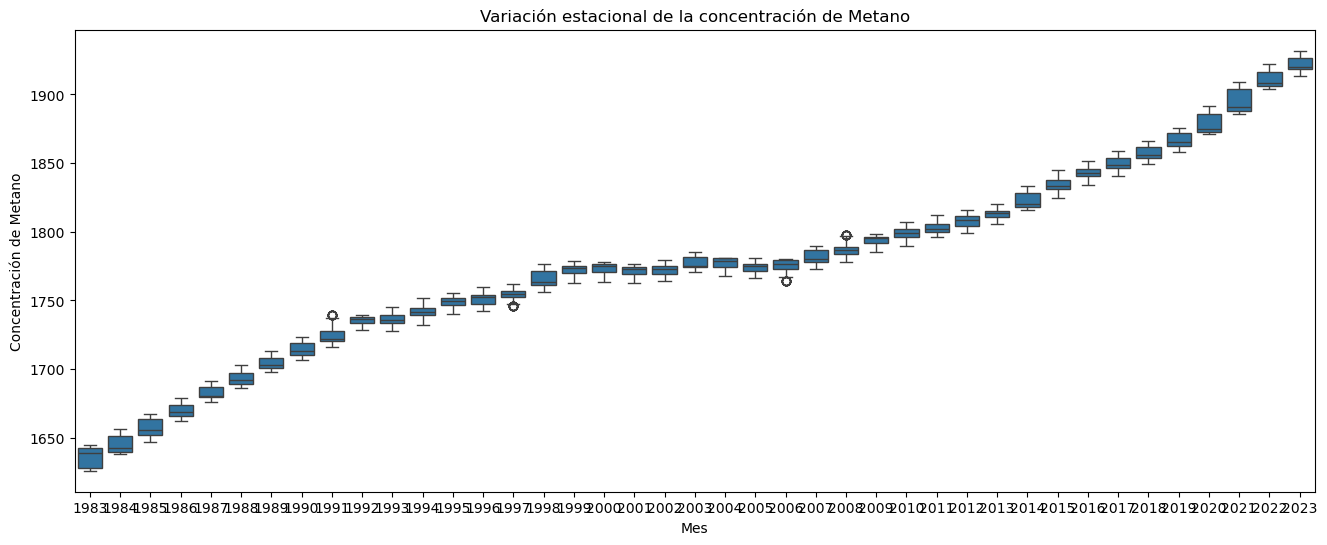

In [423]:
import seaborn as sns
plt.figure(figsize=(16, 6))

# Gráfico de caja para el metano
sns.boxplot(x='year', y='average', data=data)
plt.xlabel('Mes')
plt.ylabel('Concentración de Metano')
plt.title('Variación estacional de la concentración de Metano')
plt.show()

: Gráfico de las Tendencias Anuales de Metano y CO₂
Este gráfico mostrará cómo han evolucionado las concentraciones de metano y dióxido de carbono (CO₂) a lo largo del tiempo. Aquí, usaremos los valores de average para el metano y monthly average para el CO₂.

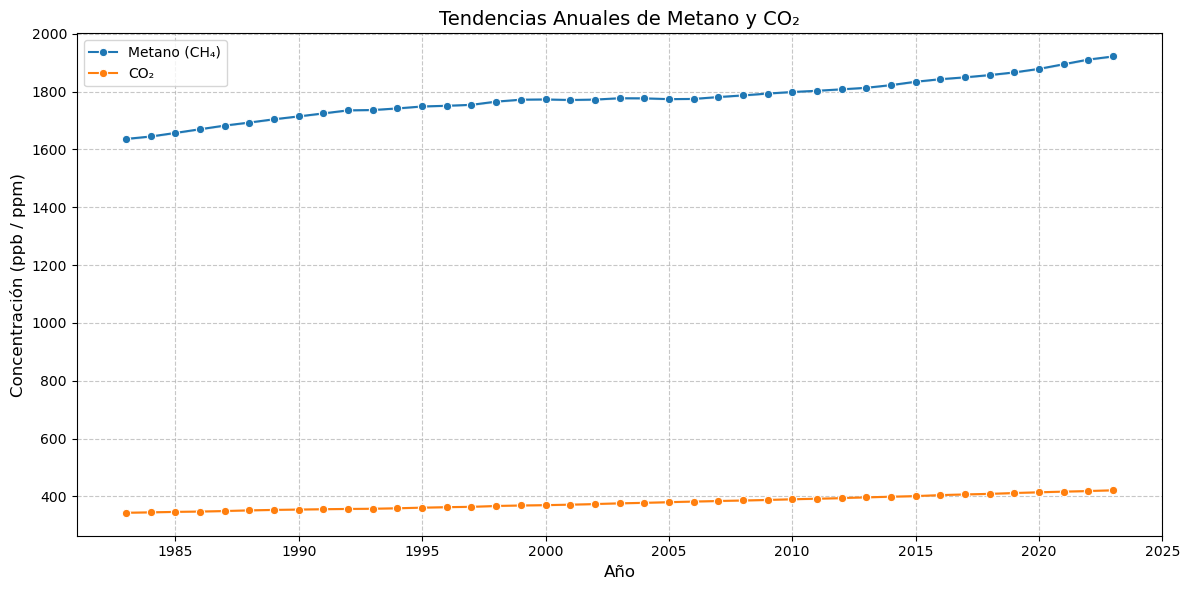

In [401]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico 1: Tendencias anuales de Metano y CO₂
plt.figure(figsize=(12, 6))

# Graficar Metano
sns.lineplot(data=data, x="year", y="average", label="Metano (CH₄)", marker="o")

# Graficar CO₂
sns.lineplot(data=data, x="year", y="monthly average", label="CO₂", marker="o")

# Agregar detalles
plt.title('Tendencias Anuales de Metano y CO₂', fontsize=14)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Concentración (ppb / ppm)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


Gráfico de Dispersión entre Metano y CO₂
Este gráfico mostrará la relación entre las concentraciones de metano y CO₂ a lo largo del tiempo. En este caso, usaremos un gráfico de dispersión (scatterplot) para ver cómo se distribuyen las concentraciones de ambos gases.

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

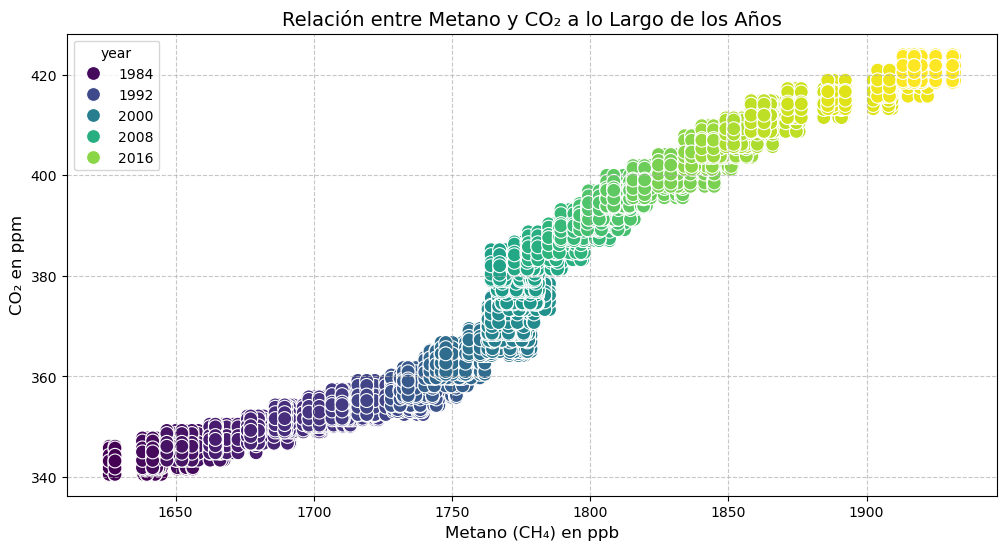

In [407]:
# Gráfico 2: Dispersión entre Metano y CO₂
plt.figure(figsize=(12, 6))

# Graficar la relación entre Metano y CO₂
sns.scatterplot(data=data, x="average", y="monthly average", hue="year", palette="viridis", s=100)

# Agregar detalles
plt.title('Relación entre Metano y CO₂ a lo Largo de los Años', fontsize=14)
plt.xlabel('Metano (CH₄) en ppb', fontsize=12)
plt.ylabel('CO₂ en ppm', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.colorbar(plt.cm.ScalarMappable(cmap="viridis"), label="Año")  # Barra de color para representar los años
plt.tight_layout()
plt.show()


3: Gráfico de la Temperatura Global, Metano y CO₂
Este gráfico mostrará las tres variables a lo largo de los años: Temperatura Global (de la columna No_Smoothing), Metano y CO₂. Aquí, vamos a utilizar el mismo enfoque para graficar las tres series.

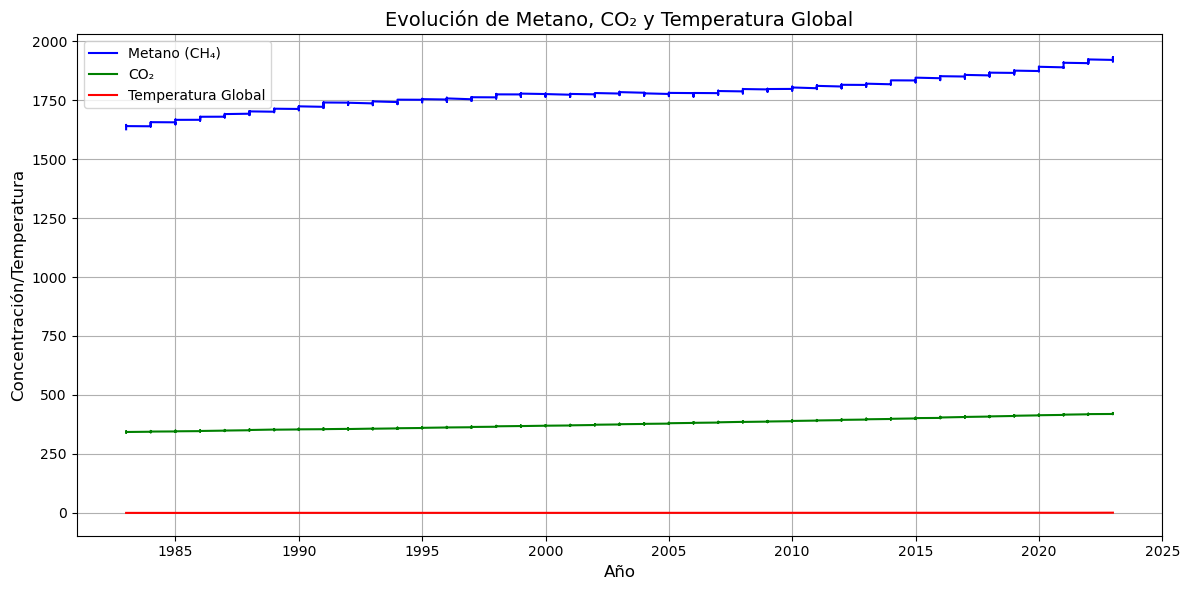

In [409]:
# Gráfico 3: Evolución de Metano, CO₂ y Temperatura Global
plt.figure(figsize=(12, 6))

# Graficar Metano
plt.plot(data['year'], data['average'], label='Metano (CH₄)', color='blue')

# Graficar CO₂
plt.plot(data['year'], data['monthly average'], label='CO₂', color='green')

# Graficar Temperatura Global
plt.plot(data['year'], data['No_Smoothing'], label='Temperatura Global', color='red')

# Agregar detalles
plt.title('Evolución de Metano, CO₂ y Temperatura Global', fontsize=14)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Concentración/Temperatura', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Explicación de los Gráficos
Gráfico de Tendencias Anuales: Este gráfico muestra cómo las concentraciones de metano (CH₄) y CO₂ han cambiado a lo largo del tiempo. Nos da una visualización clara de las tendencias anuales de ambos gases.

Gráfico de Dispersión: Este gráfico permite observar la relación directa entre las concentraciones de metano y CO₂, mostrando cómo varían conjuntamente a lo largo de los años.

Gráfico de Evolución Global: Este gráfico combina las tres variables (metano, CO₂ y temperatura global) en una sola visualización, lo que puede ayudarte a comparar las tendencias de temperatura con los gases en un mismo período.

Siguientes Pasos
Revisar las visualizaciones: ¿Estos gráficos te resultan útiles para analizar las relaciones entre las variables? Si es así, puedes continuar con análisis más detallados (como correlaciones) o modificaciones adicionales.
Explorar otros tipos de visualización: Dependiendo de lo que estés buscando, podríamos crear gráficos adicionales, como histogramas o mapas de calor para relaciones más complejas entre las variables.

PCA en el análisis climático:
Reducción de Dimensionalidad:

Si tienes muchas variables, como las concentraciones de diferentes gases de efecto invernadero, varias medidas de temperatura (por ejemplo, No_Smoothing, Lowess(5)) y otros factores, el PCA puede ayudarte a reducir esas variables a unas pocas componentes principales que resumen la mayor parte de la variabilidad en los datos.
Esto facilita la visualización, interpretación y análisis sin perder información clave.
Identificación de Patrones Subyacentes:

El PCA permite identificar cuáles son las principales fuentes de variabilidad en los datos. En un análisis de cambio climático, por ejemplo, podrías descubrir si los principales factores que afectan las variaciones de temperatura global están relacionados con una o más concentraciones de gases (metano, CO₂) de una manera más compleja de lo que parece a simple vista.
Visualización de Relaciones:

Después de aplicar PCA, puedes visualizar tus datos en 2D o 3D usando solo las primeras componentes principales, lo que facilita ver patrones y relaciones subyacentes en los datos que no son evidentes en las representaciones tradicionales.
Detección de Outliers:

El PCA también ayuda a identificar outliers o valores atípicos. Estos pueden ser importantes en el análisis de cambio climático, donde los valores extremos podrían indicar eventos climáticos inusuales o desviaciones en las tendencias de gases de efecto invernadero.
Desarrollo de Modelos Predictivos:

Al reducir la dimensionalidad de los datos, PCA puede facilitar la creación de modelos predictivos que pronostiquen la evolución de la temperatura global o la concentración de gases de efecto invernadero con un número reducido de variables, pero sin perder capacidad explicativa.


In [411]:
data_cleaned = data.drop(columns=['unc. of mon mean'])


Reduccion de dimencionalidad PCA

In [415]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Seleccionar las columnas relevantes para PCA
data_pca = data[['average', 'monthly average', 'No_Smoothing', 'Lowess(5)']]

# Escalar los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_pca)

# Aplicar PCA
pca = PCA(n_components=3)  # Seleccionamos las 3 primeras componentes
pca_components = pca.fit_transform(data_scaled)

# Resultados
print(f'Varianza explicada por cada componente: {pca.explained_variance_ratio_}')
print(f'Componentes principales: {pca.components_}')


Varianza explicada por cada componente: [0.96559585 0.02240419 0.01016921]
Componentes principales: [[ 0.49752918  0.50431777  0.49233419  0.50570283]
 [-0.52163527 -0.20504185  0.82385252 -0.08438898]
 [ 0.6930644  -0.51174948  0.26724062 -0.43169047]]


Gráfico de Varianza Explicada:
Podemos crear un gráfico de barras para mostrar qué porcentaje de la varianza es explicado por cada componente principal.

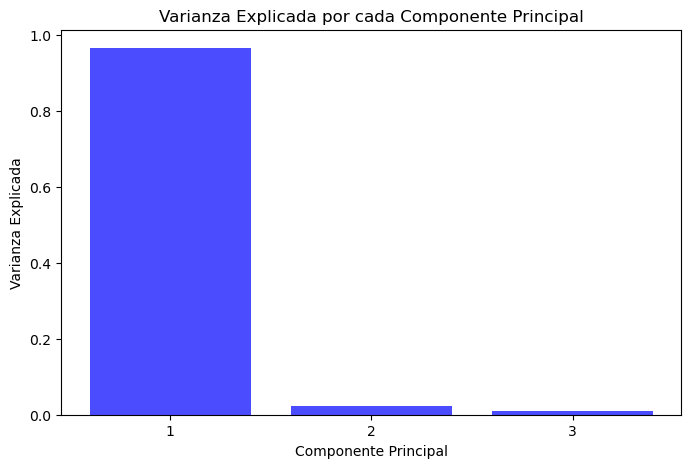

In [419]:
# Graficar la varianza explicada
import matplotlib.pyplot as plt

explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, color='b')
plt.xlabel('Componente Principal')
plt.ylabel('Varianza Explicada')
plt.title('Varianza Explicada por cada Componente Principal')
plt.xticks(range(1, len(explained_variance) + 1))
plt.show()


Los coeficientes son todos bastante altos (aproximadamente 0.5 para cada variable). Esto indica que la primera componente es una combinación de todas las variables de manera bastante equilibrada. En otras palabras, este componente refleja un patrón global que incluye las concentraciones de metano, CO2 y la temperatura global.
Componente 2:
El coeficiente negativo de metano (-0.52) y el coeficiente alto de Lowess(5) (0.82) sugieren que la segunda componente podría estar relacionada con una variabilidad en la temperatura global y CO2, pero en una relación inversa con metano.
Componente 3:
Esta componente tiene una relación mixta entre metano (0.69) y Lowess(5) (-0.43). Podría estar capturando una variabilidad que combina metano con la temperatura suavizada, pero también tiene un componente de variabilidad que afecta la temperatura global de manera no lineal.

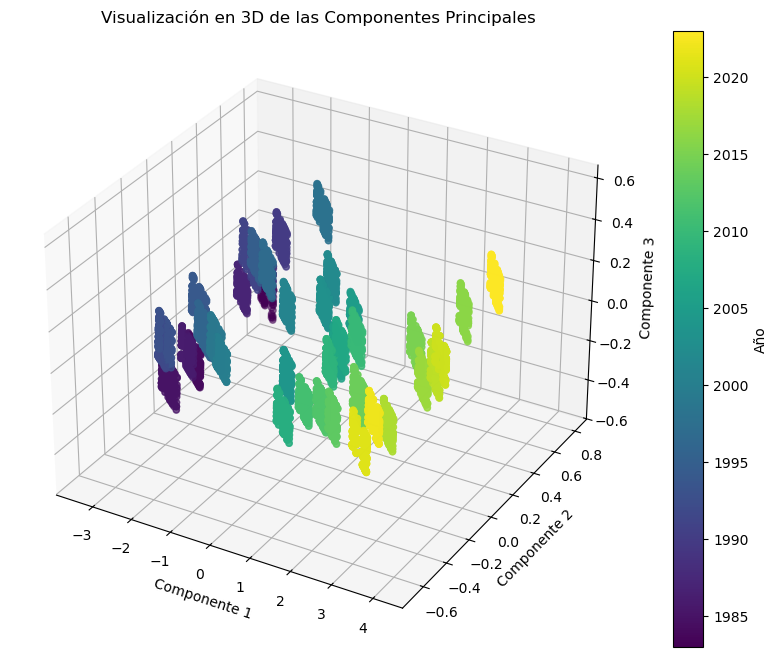

In [435]:
from mpl_toolkits.mplot3d import Axes3D

# Graficar las primeras 3 componentes en 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Usamos las tres primeras componentes
ax.scatter(pca_components[:, 0], pca_components[:, 1], pca_components[:, 2], c=data['year'], cmap='viridis')

# Etiquetas y título
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')
ax.set_title('Visualización en 3D de las Componentes Principales')
plt.colorbar(ax.scatter(pca_components[:, 0], pca_components[:, 1], pca_components[:, 2], c=data['year'], cmap='viridis'), label='Año')
plt.show()


En el gráfico de varianza explicada, verás que la primera componente es la más significativa, mientras que las otras componentes contribuyen poco a la variabilidad total.
En el gráfico 3D, podrías observar cómo se distribuyen los datos a lo largo de las tres primeras componentes principales, lo que te ayudará a identificar patrones o agrupaciones en las concentraciones de gases y la temperatura global a lo largo del tiempo.
Con estos pasos completados, tendrás una visión más clara de los patrones subyacentes en el dataset y cómo las diferentes variables se interrelacionan.

MODELO DE ML
Implementemos la regresión lineal múltiple para analizar la relación entre las concentraciones de gases y la temperatura global. A continuación, paso a paso, construimos el modelo:

Resultados del Modelo:
R²: 0.89
MAE: 0.08
RMSE: 0.09


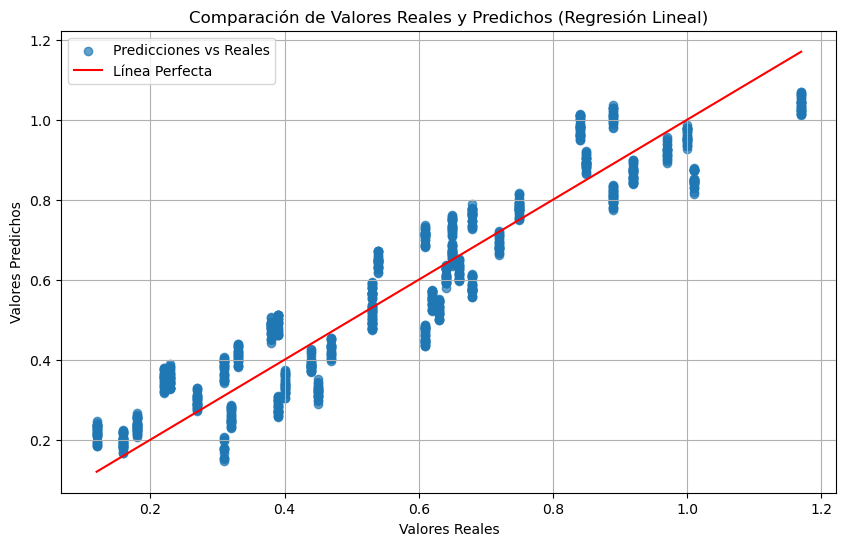

In [431]:
# Librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 1. Preparar los datos
# Seleccionamos las variables independientes y dependientes
X = data[['average', 'monthly average']]  # Gases: metano y CO₂
y = data['No_Smoothing']  # Temperatura global (sin suavizar)

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Evaluar el modelo
y_pred = model.predict(X_test)

# Métricas de evaluación
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Resultados del Modelo:")
print(f"R²: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# 5. Visualización
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, label='Predicciones vs Reales')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Línea Perfecta')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Comparación de Valores Reales y Predichos (Regresión Lineal)')
plt.legend()
plt.grid(True)
plt.show()



In [433]:
import statsmodels.api as sm

# Agregar una constante a X para el término de intercepto
X_const = sm.add_constant(X)

# Crear el modelo usando statsmodels
model_sm = sm.OLS(y, X_const).fit()

# Generar el resumen estadístico
print(model_sm.summary())


                            OLS Regression Results                            
Dep. Variable:           No_Smoothing   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                 2.189e+04
Date:                Thu, 19 Dec 2024   Prob (F-statistic):               0.00
Time:                        20:52:17   Log-Likelihood:                 5821.4
No. Observations:                5826   AIC:                        -1.164e+04
Df Residuals:                    5823   BIC:                        -1.162e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -3.8434      0.050    -